### Excercise 1:
In this tutorial, we will explore the LOFAR dynamic spectra of both the target (the Sun) and the calibrator (in this case it is CasA).
By the end of this tutorial you will be able to:
1. Prepare the `h5` raw data file from LOFAR into smaller `fits` files.
2. Plot the light curves of the target and the calibrator at a particular frequency channel.
3. Plot the radio dynamic spectra.
4. Calculate the bandpass filter of the calibrator.
5. Apply the bandpass filter to the target's data `fits` files.
6. Export the calibrated dynamic spectra as `fits` files and `png` images.

The files `h5` and `raw` of the target should be stored at `./data/sun/` folder.
Same for the calibrator files but to be stored at `./data/cal/` folder.

First we start by importing the required modules.

In [47]:
import sys
sys.path.insert(1, '../') # make sure to use the code in this repo

from __future__ import absolute_import, division
import glob
import os
import re
import json
from astropy.io import fits as fits
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
import h5py
import datetime
import numpy as np
import matplotlib
#matplotlib.use('agg') # uncomment if you do not want to show plots in the notebook
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

# try to use the precise epoch
mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00'
try:
    mdates.set_epoch('1970-01-01T00:00:00')
except:
    pass
import lofarSun


from lofarSun.BF.bftools import (model_flux,
    partition_avg,calibration_with_1bandpass_interp,get_cal_bandpass)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
print(os.path.exists('./data/cal/'),os.path.exists('./data/sun/'))

True True


Set important initial values.

In [7]:
x_points = 900 # time sample points
y_points = -1 # f samples  (-1 for not down sampling, keep origional) 
chunk_t = datetime.timedelta(minutes=15)
chop_off = False # chop every **interger** 15 minutes [00:15,00:30,00:45....]

# IMORTANT! give absolute (or relative) paths to the next array: first of the calibrator, and then of the target source
work_dir = os.getcwd()
h5dirs = ['./data/cal/', './data/sun/'] # define the paths for the calibrator and sun raw data
out_dir_base = work_dir # should be absolute dir starting from '/'
SAP_target = '000'
SAP_calibrator = '001'

Define necessary functions for the analysis.

In [8]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '#'):
    '''
    The process bar function.
    To see the process while processing
    '''
    percent = ('{0:.' + str(decimals) + 'f}').format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end ='\r')
    # Print New Line on Complete
    if iteration == total: 
        print()
        
        
def print_name(name):
    print(name)


def read_file(fname):
    '''
    This function reads a typical LOFAR LBA fits file

    Input: the path+name of the file
    Output: the dynamic spectrum, frequencies vector and time vector
    '''
    hdu = fits.open(fname)
    dyspec = hdu[0].data
    f_fits = hdu[1].data['FREQ'][:]
    t_fits = hdu[2].data['TIME'][:]
    return dyspec,f_fits,t_fits


---

Define the file name of the calibrator (CasA).

In [16]:
# cal
os.chdir(work_dir) # go back home
h5dir = './data/cal'
os.chdir(h5dir)
fname_DS = 'L887922_SAP001_B000_S0_P000_bf.h5'

m = re.search('B[0-9]{3}', fname_DS)
m.group(0)
beam_this = m.group(0)[1:4]
m = re.search('SAP[0-9]{3}', fname_DS)
m.group(0)
SAP = m.group(0)[3:6]

f = h5py.File(fname_DS, 'r')
data_lightcurve_cal = f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][11000:21000,600]

In [17]:
# check the calib. data shape
f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'].shape

(3822272, 1392)

Define the file name of the target (Sun).

In [18]:
# sun
os.chdir(work_dir) # go back home
h5dir = './data/sun'
os.chdir(h5dir)
fname_DS = 'L887922_SAP000_B000_S0_P000_bf.h5'

m = re.search('B[0-9]{3}', fname_DS)
m.group(0)
beam_this = m.group(0)[1:4]
m = re.search('SAP[0-9]{3}', fname_DS)
m.group(0)
SAP = m.group(0)[3:6]

f = h5py.File(fname_DS, 'r')
data_lightcurve_sun = f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][11000:21000, 600]

In [20]:
# check the calib. data shape
f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'].shape

(3822272, 6400)

We can see that the number of observing frequency channels of the target are bigger than that of the calibrator.

Plot the light curves of the Sun and calibrator.
* Ideally they should be aligned, but sometimes the calibrator and target observation may not be perfectly aligned because observation is not always perfect.
* The target is observed at some frequency channels while calibrator may be observed at some other channels.
* There are several factors to consider while estimating the calibration error such as background noise contribution, system error, cable noise, beam-shape, and combine them with error propagation.

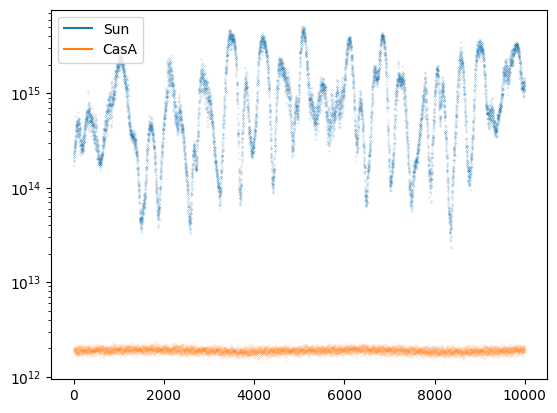

In [21]:
plt.figure()
plt.plot(data_lightcurve_sun, '.', ms=0.2)
plt.plot(data_lightcurve_cal, '.', ms=0.1)
#plt.ylim([0.0e14, 6e14])
l1, = plt.plot([], [], 'C0')
l2, = plt.plot([], [], 'C1')
plt.yscale('log')
plt.legend([l1,l2], ['Sun','CasA'], loc='upper left')
plt.show()

Now split the big raw data file of the target and the calibrator into 15-minute dynamic spectra.

This will export `fits` data files in `dB` units, `json` file describing the data file content, and `png` images of the spectra as well as the calibrator bandpass spectrum for each file.

In [30]:
# convert h5 to fits for both the source and the calibrator
for h5dir in h5dirs:
    os.chdir(work_dir) # go back home
    os.chdir(h5dir)    # the dir contains the h5
    
    if h5dir.split('/')[-2] == 'sun':
        out_dir_base_local = '/home/user01/Sun_fits'
        SAP = '000'
    elif h5dir.split('/')[-2] == 'cal':
        out_dir_base_local = '/home/user01/Cal_fits'
        SAP = '001'
    
    
    # initialize necessary directory
    out_dir = f'./{out_dir_base_local}/'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    

    for fname_DS in glob.glob('./*.h5'):
        m = re.search('B[0-9]{3}', fname_DS)
        m.group(0)
        beam_this = m.group(0)[1:4]
        
        f = h5py.File(fname_DS, 'r')
        group = f['/']
        
        # obtain name of calibrator
        target_obs = group.attrs['TARGETS']
        
        # if the calib name is missing, define it manually
        if target_obs[1] == '':
            target_obs[1] = 'CasA'
        calibrator_name = [x for x in target_obs if not x.startswith('SUN')][0]
        
        # get shape of the BF raw
        data_shape = f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'].shape
        t_lines = data_shape[0]
        f_lines = data_shape[1]

        # get the time parameters
        tsamp = f['/SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/COORDINATES/COORDINATE_0'].attrs['INCREMENT']
        tint = f['/'].attrs['TOTAL_INTEGRATION_TIME']

        t_start_bf = datetime.datetime.strptime(group.attrs['OBSERVATION_START_UTC'][0:26]+' +0000', '%Y-%m-%dT%H:%M:%S.%f %z')
        t_end_bf = datetime.datetime.strptime(group.attrs['OBSERVATION_END_UTC'][0:26]+' +0000', '%Y-%m-%dT%H:%M:%S.%f %z')

        # get the frequency axes
        freq_sun = f['/SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/COORDINATES/COORDINATE_1'].attrs['AXIS_VALUES_WORLD']/1e6
        this_ra = f['/SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this].attrs['POINT_RA']
        this_dec = f['/SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this].attrs['POINT_DEC']
        
        if chop_off:
            t_start_chunk = mdates.num2date((np.ceil(mdates.date2num(t_start_bf)*24*4.))/4/24)
        else:
            t_start_chunk = t_start_bf

        chunk_num = ((t_end_bf-t_start_chunk)/chunk_t)

        if y_points > 0:
            freq_select_idx = np.int32(np.linspace(0, f_lines-1, y_points))
        else:
            freq_select_idx = np.arange(f_lines)
        
        f_fits = freq_sun[freq_select_idx]

        for idx_cur in np.arange(int(chunk_num))[1:5]:
            printProgressBar(idx_cur+1, int(chunk_num), prefix='Progress:', suffix='Complete', length=50)

            # select the time
            t_start_fits = t_start_chunk + idx_cur*1.0*chunk_t
            t_end_fits = t_start_chunk + (idx_cur+1)*1.0*chunk_t

            t_ratio_start = (mdates.date2num(t_start_fits) 
                            - mdates.date2num(t_start_bf)) / (mdates.date2num(t_end_bf)
                                                            - mdates.date2num(t_start_bf))
            idx_start = int(t_ratio_start*(t_lines-1))
            
            t_ratio_end = (mdates.date2num(t_end_fits) 
                            - mdates.date2num(t_start_bf)) / (mdates.date2num(t_end_bf)
                                                            - mdates.date2num(t_start_bf))
            idx_end = int(t_ratio_end*(t_lines-1))

            stokes = f['/SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][idx_start:idx_end:int((idx_end-idx_start)/x_points+1),:]
            stokes = np.abs(stokes) + 1e-7
            data_fits = 10.0*np.log10(stokes)[:, freq_select_idx]
            t_fits = np.linspace(mdates.date2num(t_start_fits), mdates.date2num(t_end_fits), data_fits.shape[0])

            hdu_lofar = fits.PrimaryHDU()
            hdu_lofar.data = data_fits
            hdu_lofar.header['SIMPLE']    =                    True          
            hdu_lofar.header['BITPIX']    =                    8 
            hdu_lofar.header['NAXIS ']    =                    2          
            hdu_lofar.header['NAXIS1']    =                 x_points          
            hdu_lofar.header['NAXIS2']    =                 y_points          
            hdu_lofar.header['EXTEND']    =                    True               
            hdu_lofar.header['DATE']      =  t_start_fits.strftime('%Y-%m-%d')         
            hdu_lofar.header['CONTENT']   =  t_start_fits.strftime('%Y/%m/%d') + ' Radio Flux Intensity LOFAR ' + group.attrs['ANTENNA_SET']
            hdu_lofar.header['ORIGIN']    = 'ASTRON Netherlands'
            hdu_lofar.header['TELESCOP']  =  group.attrs['TELESCOPE']
            hdu_lofar.header['INSTRUME']  =  group.attrs['ANTENNA_SET']          
            hdu_lofar.header['OBJECT']    =  group.attrs['TARGETS'][0]         
            hdu_lofar.header['DATE-OBS']  =  t_start_fits.strftime('%Y/%m/%d')         
            hdu_lofar.header['TIME-OBS']  =  t_start_fits.strftime('%H:%M:%S.%f')       
            hdu_lofar.header['DATE-END']  =  t_end_fits.strftime('%Y/%m/%d')         
            hdu_lofar.header['TIME-END']  =  t_end_fits.strftime('%H:%M:%S.%f')          
            hdu_lofar.header['BZERO']     =                   0. 
            hdu_lofar.header['BSCALE']    =                   1. 
            hdu_lofar.header['BUNIT']     = 'digits  '           
            hdu_lofar.header['DATAMIN']   =                  np.min(data_fits) 
            hdu_lofar.header['DATAMAX']   =                  np.max(data_fits) 
            hdu_lofar.header['CRVAL1']    =               74700. 
            hdu_lofar.header['CRPIX1']    =                    0 
            hdu_lofar.header['CTYPE1']    = 'Time [UT]'          
            hdu_lofar.header['CDELT1']    =                 0.25 
            hdu_lofar.header['CRVAL2']    =                 200. 
            hdu_lofar.header['CRPIX2']    =                    0 
            hdu_lofar.header['CTYPE2']    = 'Frequency [MHz]'    
            hdu_lofar.header['CDELT2']    =                  -1.  
            hdu_lofar.header['HISTORY']   = '        '      
            hdu_lofar.header['BEAM-RA']   = this_ra 
            hdu_lofar.header['BEAM-DEC']  = this_dec

            col_freq = fits.Column(name='FREQ', format='D', array=f_fits)
            col_time = fits.Column(name='TIME', format='D', array=t_fits)
            
            hdu_f = fits.BinTableHDU.from_columns([col_freq], name='FREQ')
            hdu_t = fits.BinTableHDU.from_columns([col_time], name='TIME')

            fname = t_start_fits.strftime('LOFAR_%Y%m%d_%H%M%S_')+group.attrs['ANTENNA_SET']+'.fits'
            
            hdul = fits.HDUList([hdu_lofar, hdu_f, hdu_t])
            hdul.writeto(f'./{out_dir_base_local}/{fname}', overwrite=True)
            
            fig = plt.figure(figsize=(6,4), dpi=120)
            ax = plt.gca()
            
            bandpass_arr = [np.mean(tmp[np.where((tmp>np.sort(tmp)[int(0.03*tmp.shape[0])]) 
                        & (tmp<np.sort(tmp)[int(0.2*tmp.shape[0])]))]) for tmp in list(data_fits.T)]

            data_fits_new = data_fits-np.tile(np.mean(data_fits,0), (data_fits.shape[0],1))
            data_fits_new = data_fits-np.tile(bandpass_arr, (data_fits.shape[0],1))

            im = ax.imshow(data_fits_new.T, aspect='auto', origin='lower', 
                    vmin=(np.mean(data_fits_new)-2*np.std(data_fits_new)),
                    vmax=(np.mean(data_fits_new)+3*np.std(data_fits_new)),
                    extent=[t_fits[0],t_fits[-1],f_fits[0],f_fits[-1]],
                    cmap='inferno')

            ax.xaxis_date()
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax.set_xlabel('Time (UT)')
            ax.set_ylabel('Frequency (MHz)')
            ax.set_title(hdu_lofar.header['CONTENT'])
            cbar = plt.colorbar(im)
            cbar.set_label('Power [dB]', rotation=270, verticalalignment='baseline')
            #fig.savefig(f"./{out_dir_base_local}/{fname.split('.')[0]}.png")
            plt.close()

            plt.figure()
            plt.plot(bandpass_arr)
            #plt.gcf().savefig(f"./{out_dir_base_local}/{fname.split('.')[0]}_bandpass.png")

            lofar_json_dict = {}
            
            lofar_json_dict['telescope'] = 'LOFAR'
            lofar_json_dict['instrume'] = group.attrs['ANTENNA_SET']
            lofar_json_dict['projectID'] = group.attrs['PROJECT_ID']
            lofar_json_dict['obsID'] = group.attrs['OBSERVATION_ID']
            lofar_json_dict['source'] = fname_DS
            lofar_json_dict['date'] = t_start_fits.strftime('%Y-%m-%d')
            lofar_json_dict['time'] = t_start_fits.strftime('%H:%M:%S.%f')
            lofar_json_dict['event'] = {'detection':True, 'type':'III', 'level':'strong'}
            lofar_json_dict['n_freq'] = len(f_fits)
            lofar_json_dict['n_time'] = len(t_fits)
            lofar_json_dict['freq_range'] = [np.min(f_fits), np.max(f_fits)]
            lofar_json_dict['time_range'] = [t_start_fits.strftime('%Y-%m-%d %H:%M:%S.%f'), 
                                             t_end_fits.strftime('%Y-%m-%d %H:%M:%S.%f')]
            
            plt.close()
            #with open(f"./{out_dir_base_local}/{fname.split('.')[0]}.json", 'w') as fp:
            #    json.dump(lofar_json_dict, fp)

print('Calibrator:', calibrator_name)

# go back home
os.chdir(work_dir)

Calibrator: CasA---------------------------------------------| 11.4% Complete


Calculate the bandpass filter using the calibrator data file.

In [32]:
os.chdir(work_dir) # go back home
h5dir = './data/sun'
fname_DS = 'L887922_SAP000_B000_S0_P000_bf.h5'
bandpass_cal = get_cal_bandpass(freq_select_idx, h5dir, fname_DS, [0.4,0.43])

Bulding Cal-bandpass: 100%|##########| 6400/6400 [00:12<00:00, 520.63it/s]


This is how the calibrator bandpass spectrum looks like.

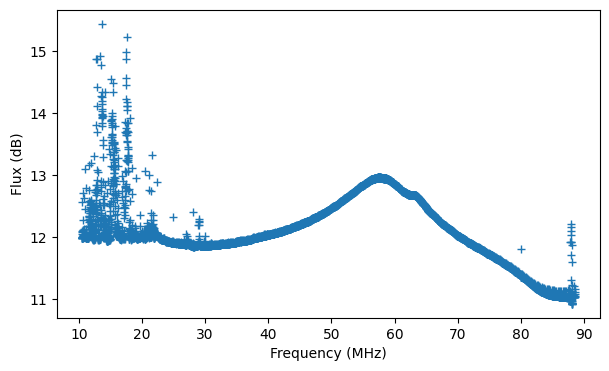

In [34]:
plt.figure(figsize=(7,4))
plt.plot(freq_sun, np.log10(bandpass_cal), '+')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (dB)')
plt.show()

In [35]:
# import one of the Sun files
dyspec_sun, f_fits_sun, t_fits_sun = read_file(f'{h5dir}/Sun_fits/LOFAR_20230428_062600_LBA_OUTER.fits')

Now we will calibrate the target data by applying the bandpass correction to the files one-by-one with the calibrator bandpass and export the output file as `fits` file and `png` image.

If you want to not show the plots in the notebook, uncomment this line `plt.close()`.

In [44]:
# go back home
os.chdir(work_dir)

# save the name of the files
names_calibrator = []
names_sun = []
calibrator = True

for h5dir in h5dirs:
    if calibrator == True:
        for file in os.listdir(f'{h5dir}Cal_fits'):
            if file.endswith('.fits'):
                path_calibrator = f'{h5dir}Cal_fits/'
                names_calibrator.append(file)
        calibrator = False
    else: 
        for file in os.listdir(f'{h5dir}Sun_fits'):
            if file.endswith('.fits'):
                path_sun = f'{h5dir}Sun_fits/'
                names_sun.append(file)


# calibrate file by file
for i in range(len(names_calibrator)):
    data_calibrated, f_fits, t_fits = calibration_with_1bandpass(path_sun+names_sun[i], bandpass_cal, calibrator_name)
    
    hdu = fits.open(path_sun+names_sun[i])
    hdu[0].data = data_calibrated
    hdu[1].data['FREQ'] = f_fits
    hdu[2].data['TIME'] = t_fits
    
    out_dir_base = f'{h5dir}out'
    if not os.path.exists(out_dir_base):
        os.makedirs(out_dir_base)
    
    hdu.writeto(f'{out_dir_base}/{names_sun[i]}', overwrite=True)

    fig = plt.figure(figsize=(6,4), dpi=120)
    ax = plt.gca()
   
    data_fits_new = (data_calibrated)
    im = ax.imshow((data_fits_new.T), aspect='auto', origin='lower',
                   extent=[t_fits[0],t_fits[-1], f_fits[0],f_fits[-1]],
                   cmap='inferno', norm=matplotlib.colors.LogNorm(vmin=1, vmax=100))

    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.setp(ax.get_xticklabels(), rotation=20, fontsize=10)
    ax.set_xlabel('Time (UT)')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_title(hdu_lofar.header['CONTENT'])
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(r'$\rm Flux [sfu]$', rotation=270, verticalalignment='baseline')
    plt.tight_layout()
    fig.savefig(f'{out_dir_base}/{names_sun[i][:-5]}.png')
    #plt.close()

NameError: name 'calibration_with_1bandpass' is not defined

### Read the Sun calibrated file

Choose one `fits` file to plot by setting the file index at `file_number`.

In [14]:
# go back home
os.chdir(work_dir)

dir_Target_fits = f'./data/sun/Sun_fits'
dir_Calibrator_fits = f'./data/cal/Cal_fits'
dir_Sun_calibrated_fits = f'./data/sun/out'

file_number = 20

Plot the dynamic spectrum of the target (Sun) and the calibrator (CasA)

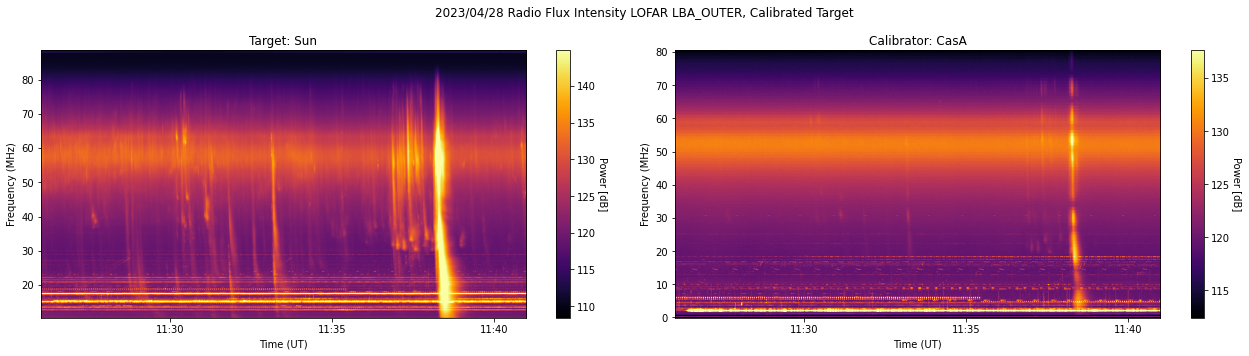

In [15]:
fig = plt.figure(figsize=(18,5))
fig.suptitle(f"{hdu_lofar.header['CONTENT']}, Calibrated Target")

ax = fig.add_subplot(121)

DATA_sun = sorted(glob.glob(f'{dir_Target_fits}/*.fits'))[file_number]

TARGET_IMAGE = fits.open(DATA_sun)[0].data.T
TARGET_FREQS = fits.open(DATA_sun)[1].data['FREQ']
TARGET_TIMES = fits.open(DATA_sun)[2].data['TIME']

im = ax.imshow(TARGET_IMAGE, aspect='auto', origin='lower', 
        vmin=(np.mean(TARGET_IMAGE)-2*np.std(TARGET_IMAGE)),
        vmax=(np.mean(TARGET_IMAGE)+3*np.std(TARGET_IMAGE)),
        extent=[TARGET_TIMES[0],TARGET_TIMES[-1], TARGET_FREQS[0],TARGET_FREQS[-1]],
        cmap='inferno')

ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title('Target: Sun')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Power [dB]', rotation=270, verticalalignment='baseline')



ax = fig.add_subplot(122)

DATA_cal = sorted(glob.glob(f'{dir_Calibrator_fits}/*.fits'))[file_number]

TARGET_IMAGE = fits.open(DATA_cal)[0].data.T
TARGET_FREQS = fits.open(DATA_cal)[1].data['FREQ']
TARGET_TIMES = fits.open(DATA_cal)[2].data['TIME']

im = ax.imshow(TARGET_IMAGE, aspect='auto', origin='lower', 
        vmin=(np.mean(TARGET_IMAGE)-2*np.std(TARGET_IMAGE)),
        vmax=(np.mean(TARGET_IMAGE)+3*np.std(TARGET_IMAGE)),
        extent=[TARGET_TIMES[0],TARGET_TIMES[-1], TARGET_FREQS[0],TARGET_FREQS[-1]],
        cmap='inferno')

ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title('Calibrator: CasA')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Power [dB]', rotation=270, verticalalignment='baseline')

plt.tight_layout()
plt.show()

Plot the bandpass spectrum 

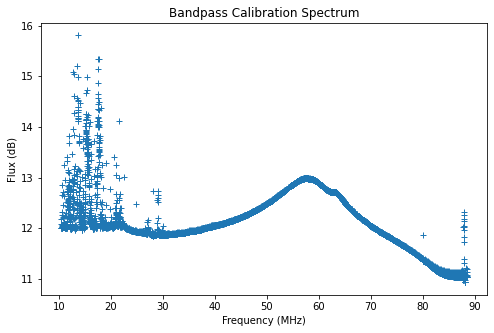

In [16]:
plt.figure(figsize=(8,5))
plt.plot(freq_sun, np.log10(bandpass_cal), '+')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (dB)')
plt.title('Bandpass Calibration Spectrum')
plt.show()

If the data array has a very large dynamic range between the minimum and maximum values, setting `vmin=0` and `vmax=np.max(arr)` can cause the lower end of the colorbar to be compressed, resulting in a mostly black image.

To address this issue, we can use a logarithmic color scale to stretch the dynamic range of the colorbar. This can be done by setting the `norm` argument of the `imshow` function to a `LogNorm` instance.

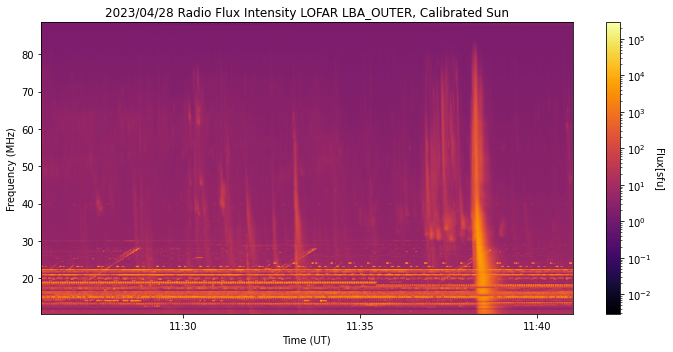

In [30]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

DATA_sun_calib = sorted(glob.glob(f'{dir_Sun_calibrated_fits}/*.fits'))[file_number]

TARGET_IMAGE = fits.open(DATA_sun_calib)[0].data.T
TARGET_FREQS = fits.open(DATA_sun_calib)[1].data['FREQ']
TARGET_TIMES = fits.open(DATA_sun_calib)[2].data['TIME']

im = ax.imshow(TARGET_IMAGE, aspect='auto', origin='lower',
        norm=LogNorm(vmin=TARGET_IMAGE.min(), vmax=TARGET_IMAGE.max()),
        extent=[TARGET_TIMES[0],TARGET_TIMES[-1], TARGET_FREQS[0],TARGET_FREQS[-1]],
        cmap='inferno')

ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f"{hdu_lofar.header['CONTENT']}, Calibrated Sun")
cbar = ax.figure.colorbar(im)
cbar.set_label(r'$\rm Flux [sfu]$', rotation=270, verticalalignment='baseline')
plt.tight_layout()
plt.show()